##### Copyright 2020 Google LLC. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

> http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn import linear_model as sklearn_linear_model
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1 as tf

In [2]:
tf.disable_eager_execution()

This colab contains TensorFlow code for implementing the surrogate projected gradient descent method presented in the paper:
> Qijia Jiang, Olaoluwa Adigun, Harikrishna Narasimhan, Mahdi M. Fard, Maya Gupta, 'Optimizing Black-box Metrics with Adaptive Surrogates', ICML 2020. [[PDF]](https://arxiv.org/pdf/2002.08605.pdf)

We consider the problem of learning with noisy training labels, given access to a small validation sample with the true labels. We seek to train a linear classifier that performs well on the G-mean metric. We apply the approach proposed in the paper to adaptively combine surrogates on the training set to best optimize the given metric on the validation sample. We will demostrate the effectiveness of this approach on the [UCI Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult).

## Load dataset

The data preprocessing code has been adapted from  <a href="https://github.com/google-research/tensorflow_constrained_optimization/blob/master/examples/jupyter/Fairness_adult.ipynb">this colab</a>.

In [3]:
CATEGORICAL_COLUMNS = [
    'workclass', 'education', 'marital_status', 'occupation', 'relationship',
    'race', 'gender', 'native_country'
]
CONTINUOUS_COLUMNS = [
    'age', 'capital_gain', 'capital_loss', 'hours_per_week', 'education_num'
]
COLUMNS = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'gender',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
    'income_bracket'
]
LABEL_COLUMN = 'label'

# We'll find it useful to consider two groups of examples.
GROUPS = ['private_workforce', 'non_private_workforce']


def get_adult_data():
  train_df_raw = pd.read_csv(
      "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", 
      names=COLUMNS, skipinitialspace=True)
  test_df_raw = pd.read_csv(
      "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test", 
      names=COLUMNS, skipinitialspace=True, skiprows=1)

  train_df_raw[LABEL_COLUMN] = (train_df_raw['income_bracket'].apply(
      lambda x: '>50K' in x)).astype(int)
  test_df_raw[LABEL_COLUMN] = (test_df_raw['income_bracket'].apply(
      lambda x: '>50K' in x)).astype(int)

  # Preprocessing Features
  pd.options.mode.chained_assignment = None  # default='warn'

  # Functions for preprocessing categorical and continuous columns.
  def binarize_categorical_columns(
      input_train_df, input_test_df, categorical_columns=[]):

      def fix_columns(input_train_df, input_test_df):
          test_df_missing_cols = set(input_train_df.columns) - set(
              input_test_df.columns)
          for c in test_df_missing_cols:
              input_test_df[c] = 0
              train_df_missing_cols = set(input_test_df.columns) - set(
                  input_train_df.columns)
          for c in train_df_missing_cols:
              input_train_df[c] = 0
              input_train_df = input_train_df[input_test_df.columns]
          return input_train_df, input_test_df

      # Binarize categorical columns.
      binarized_train_df = pd.get_dummies(
          input_train_df, columns=categorical_columns)
      binarized_test_df = pd.get_dummies(
          input_test_df, columns=categorical_columns)
      # Make sure the train and test dataframes have the same binarized columns.
      fixed_train_df, fixed_test_df = fix_columns(
          binarized_train_df, binarized_test_df)
      return fixed_train_df, fixed_test_df

  def bucketize_continuous_column(input_train_df,
                                input_test_df,
                                continuous_column_name,
                                num_quantiles=None,
                                bins=None):
      assert (num_quantiles is None or bins is None)
      if num_quantiles is not None:
          train_quantized, bins_quantized = pd.qcut(
            input_train_df[continuous_column_name],
            num_quantiles,
            retbins=True,
            labels=False)
          input_train_df[continuous_column_name] = pd.cut(
            input_train_df[continuous_column_name], bins_quantized, 
            labels=False)
          input_test_df[continuous_column_name] = pd.cut(
            input_test_df[continuous_column_name], bins_quantized, labels=False)
      elif bins is not None:
          input_train_df[continuous_column_name] = pd.cut(
            input_train_df[continuous_column_name], bins, labels=False)
          input_test_df[continuous_column_name] = pd.cut(
            input_test_df[continuous_column_name], bins, labels=False)

  # Filter out all columns except the ones specified.
  train_df = (
      train_df_raw[CATEGORICAL_COLUMNS + CONTINUOUS_COLUMNS + [LABEL_COLUMN]])
  test_df = (
      test_df_raw[CATEGORICAL_COLUMNS + CONTINUOUS_COLUMNS + [LABEL_COLUMN]])
  
  # Bucketize continuous columns.
  bucketize_continuous_column(train_df, test_df, 'age', num_quantiles=4)
  bucketize_continuous_column(
      train_df, test_df, 'capital_gain', bins=[-1, 1, 4000, 10000, 100000])
  bucketize_continuous_column(
      train_df, test_df, 'capital_loss', bins=[-1, 1, 1800, 1950, 4500])
  bucketize_continuous_column(
      train_df, test_df, 'hours_per_week', bins=[0, 39, 41, 50, 100])
  bucketize_continuous_column(
      train_df, test_df, 'education_num', bins=[0, 8, 9, 11, 16])
  
  train_df, test_df = binarize_categorical_columns(
      train_df, test_df, 
      categorical_columns=CATEGORICAL_COLUMNS + CONTINUOUS_COLUMNS)
  feature_names = list(train_df.keys())
  feature_names.remove(LABEL_COLUMN)
  num_features = len(feature_names)

  # Include workclass that is not private.
  train_df["private_workforce"] = train_df["workclass_Private"]
  train_df["non_private_workforce"] = 1- train_df["workclass_Private"]
  test_df["private_workforce"] = test_df["workclass_Private"]
  test_df["non_private_workforce"] = 1 - test_df["workclass_Private"]
  
  return train_df, test_df, feature_names

We separate out the train and test features, labels and group memberships. 

In [4]:
# Train and test features, labels.
train_df, test_df, feature_names = get_adult_data()

x_train = np.array(train_df[feature_names])
y_train = np.array(train_df[LABEL_COLUMN])

x_test = np.array(test_df[feature_names])
y_test = np.array(test_df[LABEL_COLUMN])

# Train and test group memberships. We maintain a list of group memberships 'z'
# where each entry is an array of boolean memberships of shape (n,).
z_train = [np.array(train_df[g]) for g in GROUPS]
z_test = [np.array(test_df[g]) for g in GROUPS]

## Add noise to training labels
We retain 1% of the training sample for validation and in the remaining data, randomly pick 30% of the positive labels and flip them to negative.

In [5]:
# Split training sample into validation and training sets.
train_indices, vali_indices = train_test_split(
    np.arange(x_train.shape[0]), test_size=0.01, random_state=40)

x_vali = x_train[vali_indices, :]
y_vali = y_train[vali_indices]
z_vali = [z_train[kk][vali_indices] for kk in range(len(z_train))]

x_train = x_train[train_indices, :]
y_train = y_train[train_indices]
z_train = [z_train[kk][train_indices] for kk in range(len(z_train))]

# Flip 30% of positive training labels.
np.random.seed(123456)
noise_indicators = np.random.rand(x_train.shape[0],) <= 0.3
y_train[(y_train == 1) * noise_indicators] = 0

## Evaluation function
We include a function to evaluate the G-mean metric for given labels and predicted scores: $\text{G-mean} = 1 - \sqrt{\text{TPR} \times \text{TNR}}$.

In [6]:
def g_mean(labels, scores):  
  tpr = np.sum((labels > 0) & (scores > 0)) / np.sum(labels > 0)
  tnr = np.sum((labels <= 0) & (scores <= 0)) / np.sum(labels <= 0)
  return 1 - np.sqrt(tpr * tnr)


def print_results(linear_model, x_vali, y_vali, x_test, y_test):
  weights, threshold = linear_model
  scores_vali = np.dot(x_vali, weights) + threshold
  scores_test = np.dot(x_test, weights) + threshold

  print("Vali G-mean: %.4f" % g_mean(y_vali, scores_vali))
  print("Test G-mean: %.4f" % g_mean(y_test, scores_test))

## Train classifier with cross-entropy loss

As our first baseline, we  train a linear model by optimizing a plain cross-entropy loss.

In [7]:
def optimize_cross_entropy_loss(
    x_train, y_train, x_vali, y_vali, learning_rate=0.1, loops=1000):
  tf.reset_default_graph()

  # Set random seed for reproducibility.
  np.random.seed(123456)
  random.seed(654321)
  tf.set_random_seed(121212)  

  # Linear model.
  dimension = x_train.shape[-1]
  weights = tf.Variable(tf.zeros(dimension, dtype=tf.float32), name="weights")
  threshold = tf.Variable(0, name="threshold", dtype=tf.float32)

  # Labels and predictions on train set.
  features_tensor = tf.constant(x_train.astype("float32"), name="features")
  labels_tensor = tf.constant(y_train.astype("float32"), name="labels")
  predictions_tensor = tf.tensordot(
      features_tensor, weights, axes=(1, 0)) + threshold

  # Labels and predictions on vali set.
  features_tensor_vali = tf.constant(
      x_vali.astype("float32"), name="features_vali")
  labels_tensor_vali = tf.constant(
      y_vali.astype("float32"), name="labels_vali")
  predictions_tensor_vali = tf.tensordot(
      features_tensor_vali, weights, axes=(1, 0)) + threshold
  
  # Cross-entropy loss.
  loss_tensor_train = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
      labels=labels_tensor, logits=predictions_tensor))
  loss_tensor_vali = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
      labels=labels_tensor_vali, logits=predictions_tensor_vali))
  
  # Optimizer.
  train_op = tf.train.AdagradOptimizer(learning_rate).minimize(
      loss_tensor_train)
  
  # Start TF session and initialize variables.
  session = tf.Session()
  session.run(tf.global_variables_initializer())

  # We maintain a list of objectives and model weights during training.
  best_model = None
  min_loss = 1e10

  # Perform full gradient updates.
  for ii in range(loops):
    # Gradient updates.session.run(train_op)
    session.run(train_op)
    if (ii % 10 == 0):
      model = [session.run(weights), session.run(threshold)]
      loss_vali = session.run(loss_tensor_vali)
      if loss_vali < min_loss:
        min_loss = loss_vali
        best_model = model

  session.close()
  return best_model

In [18]:
model_ce = optimize_cross_entropy_loss(x_train, y_train, x_vali, y_vali)
print_results(model_ce, x_vali, y_vali, x_test, y_test)

Vali G-mean: 0.4908
Test G-mean: 0.4396


## Post-shift previous model

As our second baseline, we tune a threshold on the previously trainined model that optimizes G-mean on the validation set.

In [9]:
def post_shift(linear_model, x_vali, y_vali, bin_size=0.001):
  # Compute class probabilities.
  weights, threshold = linear_model
  sigmoid = lambda x: 1 / (1 + np.exp(-x))
  y_prob = sigmoid(np.dot(x_vali, weights) + threshold)

  # Tune threshold on the probabilities to minimize G-mean on validation set.
  min_gm = 2.0
  min_threshold = -1
  for tt in np.arange(bin_size, 1, bin_size):
    gm = g_mean(y_vali, y_prob - tt)
    if gm < min_gm:
      min_gm = gm
      min_threshold = tt

  # Apply log transform to the threshold to translate it from the [0, 1] range 
  # to the real line.
  post_shifted_threshold = (
      threshold - np.log(min_threshold / (1 - min_threshold)))
  
  return (weights, post_shifted_threshold)

In [10]:
model_ps = post_shift(model_ce, x_vali, y_vali)
print_results(model_ps, x_vali, y_vali, x_test, y_test)

Vali G-mean: 0.1716
Test G-mean: 0.1827


## Proposed method
We next apply our proposed method to adaptively combine surrogates on the training set to best optimize the G-mean on the validation sample. We use *four surrogate losses*, each of this is the *sigmoid* loss averaged over the positive and negative examples, evaluated separately on two groups of examples: 'private-workforce' and 'non-private-workforce'. There is no particular reason for choosing these two groups. Our approach works with any choice of surrogates and data partitioning. 

We begin by writing a function that computes the sigmoid surrogate for a given real-valued input. We additionally write a function that computes a surrogate tensor for a 1-dimensional tensor input. The former would be needed for gradient computation using NumPy operations and the latter would be needed for optimizing the surrogates in TensorFlow.

In [11]:
# Sigmoid surrogate functions.
def surrogate_fn(x, sigma_scale=1.5):
  x1 = -np.maximum(0, x * sigma_scale)
  x2 = np.minimum(0, x * sigma_scale)
  return np.exp(x2) / (np.exp(x1) + np.exp(x2))

def surrogate_tensor_fn(x, sigma_scale=1.5): 
  return tf.math.sigmoid(-x * sigma_scale)

We also write a function that computes the metric. This function takes an array of labels and an array of predictions at different perturbations of the model and outputs the metric value for each set of predictions.

In [12]:
# G-mean metric function.
def metric_fn(labels, predictions):
  """Computes metric for given labels and predictions.

  Args: 
    labels: NumPy array of shape (n,), where n is the number of data points
    predictions: NumPy array of shape (m, n), where n is the number of data 
      points and m >= 1 is the number of perturbations.
  
  Returns:
    A NumPy array of metric values of shape (n,)
  """
  if predictions.ndim < 2:
    predictions = predictions.reshape(1, -1)
  tpr = np.mean(predictions[:, y_vali > 0] > 0, axis=1)
  tnr = np.mean(predictions[:, y_vali <= 0] <= 0, axis=1)
  return 1.0 - np.sqrt(tpr * tnr)

The proposed algorithm runs *projected gradient descent (PGD)* over the space of surrogates. We first write a function to estimate gradients w.r.t. the surrogates for the current linear model and performs a gradient update in surrogate space. We use the linear interpolation based strategy described in Algorithm 3 in the paper for the gradient estimation step. The output is $K$-dimensional profile of updated surrogate values, where $K$ is the number of surrogates used (in this case, $K = 2 \times \text{number of groups} = 4$).

In [13]:
def surrogate_gradient_update(
    linear_model, x_train, y_train, z_train, x_vali, y_vali, z_vali,
    surrogate_fn, metric_fn, step_size, sigma, num_perturbations):
  """
  Returns updated surrogate profile after performing gradient descent update.
  
  Estimates gradients w.r.t. the surrogates for given linear model and performs
  a gradient descent update. Implements lines 4-5 in Algorithm 1 in the paper 
  and uses Algorithm 3 for the gradient descent update.

  Args:
    linear_model: (weights, threshold)
    x_train, y_train, z_train: Training features, labels, list of boolean
      group memberships
    x_vali, y_vali, z_vali: Validation features, labels, list of boolean
      group memberships
    surrogate_fn: A function that takes a scalar input and outputs a real-value
    metric_fn: A function that takes  as input the labels and predictions at
      different perturbations of the model, and outputs an array of metrics
    step_size: Step size of gradient descent update
    sigma: Perturbation parameter for gradient computation
    num_perturbations: Number of model peturbations for gradient computation

  Returns:
    a K-dim vector containing values for the K surrogates after gradient descent
    update (K = 2 x number of groups)
  """
  model_weights, threshold = linear_model

  num_train = x_train.shape[0]
  num_vali = x_vali.shape[0]

  ############ Line 4 in Algorithm 1 #######################################
  ############ Gradient estimation using Algorithm 3 #######################

  # Model dimension and number of groups.
  dimension = model_weights.shape[0]
  num_groups = len(z_train)

  # Unperturbed predictions on train and vali.
  predictions_train = np.dot(x_train, model_weights) + threshold 
  predictions_vali = np.dot(x_vali, model_weights) + threshold 

  # Perturbed predictions on train and vali sets by perturbing model weights.
  perturbations = np.random.normal(size=(num_perturbations, dimension)) * sigma
  perturbed_weights = model_weights.reshape(
      1, -1) + perturbations   # shape (num_perturbations, dimension)
  perturbed_predictions_train = np.dot(
      perturbed_weights, x_train.T) + threshold 
  perturbed_predictions_vali = np.dot(perturbed_weights, x_vali.T) + threshold 

  # Differences between unperturbed and perturbed surrogates on train set 
  # for each group.
  fpr_surrogate_diffs = np.zeros((num_perturbations, num_groups))
  fnr_surrogate_diffs = np.zeros((num_perturbations, num_groups))

  for group in range(num_groups):
    neg_group_indices = (y_train <= 0) & (z_train[group] == 1)
    pos_group_indices = (y_train > 0) & (z_train[group] == 1)

    # Unperturbed surrogates on train set for group.
    fpr_surrogate_train = np.mean(
        surrogate_fn(predictions_train[neg_group_indices]))
    fnr_surrogate_train = np.mean(
        surrogate_fn(-predictions_train[pos_group_indices]))
    
    # Perturbed surrogates on train set for group.
    perturbed_fpr_surrogate_train = np.mean(
        surrogate_fn(perturbed_predictions_train[:, neg_group_indices]), axis=1)
    perturbed_fnr_surrogate_train = np.mean(
        surrogate_fn(-perturbed_predictions_train[:, pos_group_indices]), axis=1)
    
    # Differences between unperturbed and perturbed surrogates for group.
    fpr_surrogate_diffs[:, group] =(
        perturbed_fpr_surrogate_train - fpr_surrogate_train)
    fnr_surrogate_diffs[:, group] = (
        perturbed_fnr_surrogate_train - fnr_surrogate_train)

  # Concatenate the fpr and fnr surrogate differences.
  surrogate_diffs = np.concatenate(
      [fpr_surrogate_diffs, fnr_surrogate_diffs], axis=1)
  
  # Calculate the differences in G-mean metric with and without perturbations.
  gm_vali = metric_fn(y_vali, predictions_vali)
  perturbed_gm_vali = metric_fn(y_vali, perturbed_predictions_vali)
  metric_diffs = perturbed_gm_vali - gm_vali

  # Fit linear regression model from surrogate diffs to metric diffs. The 
  # fitted linear coefficients gives the surrogates.
  reg_model = sklearn_linear_model.LinearRegression()
  reg_model.fit(surrogate_diffs, metric_diffs)
  grad = reg_model.coef_

  ############ Line 5 in Algorithm 1 #######################################
  ############ Gradient descent update in surrogate space ##################
  fpr_surrogate_train_new = fpr_surrogate_train - step_size * grad[:num_groups]
  fnr_surrogate_train_new = fnr_surrogate_train - step_size * grad[num_groups:]
  
  return fpr_surrogate_train_new, fnr_surrogate_train_new

We are now ready to write the main PGD routine which calls the above routine.

In [16]:
def surrogate_pgd(
    x_train, y_train, z_train, x_vali, y_vali, z_vali, surrogate_fn, 
    surrogate_tensor_fn, metric_fn, step_size_outer=0.1, step_size_inner=1.0,
    outer_loops=250, inner_loops=100, sigma=1.0, num_perturbations=100):
  """
  Trains a linear model by running projected gradient descent in surrogate 
  space with given surrogates and metric.
  
  Implements Algorithm 1 in the paper, with calls to Algorithm 3 to estimate
  gradients.

  Args:
    x_train, y_train, z_train: Training features, labels, list of boolean
      group memberships
    x_vali, y_vali, z_vali: Validation features, labels, list of boolean
      group memberships
    surrogate_fn: A function that takes a scalar input and outputs a real-value
    surrogate_tensor_fn: A function that takes a tensor input and outputs 
      a tensor of surrogate values.
    metric_fn: A function that takes  as input the labels and predictions at
      different perturbations of the model, and outputs an array of metrics
    step_size_outer: Step size for outer projected gradient descent
    step_size_inner: Step size for inner Adagrad subroutine to implement the
      projection step
    outer_loops: Number of steps to run the outer projected gradient descent
    inner_loops: Number of steps to run the inner Adagrad subroutine
    sigma: Perturbation parameter for gradient computation
    num_perturbations: Number of model peturbations for gradient computation

  Returns:
  """
  tf.reset_default_graph()

  # Set random seed for reproducibility.
  np.random.seed(123456)
  random.seed(654321)
  tf.set_random_seed(121212)  

  # Model dimension and number of groups.
  dimension = x_train.shape[-1]
  num_groups = len(z_train)
 
  # Linear model.
  weights = tf.Variable(
      tf.zeros((dimension,), dtype=tf.float32), name="weights")
  threshold = tf.Variable(0, name="threshold", dtype=tf.float32)

  # Labels, groups, predictions on train set.
  features_tensor = tf.constant(x_train.astype("float32"), name="features")
  labels_tensor = tf.constant(y_train.astype("float32"), name="labels")
  groups_tensor = [tf.constant(z_train[kk].astype("float32"), name="g_%d" % kk) 
                   for kk in range(num_groups)]
  predictions_tensor = tf.tensordot(
      features_tensor, weights, axes=(1, 0)) + threshold
  
  # Predictions on vali set.
  features_vali_tensor = tf.constant(
      x_vali.astype("float32"), name="features_vali")
  predictions_vali_tensor = tf.tensordot(
      features_vali_tensor, weights, axes=(1, 0)) + threshold

  # Surrogate tensors for each group.
  fpr_surrogates = []
  fnr_surrogates = []

  for group in range(num_groups):
    # Surrogate on fpr for group.
    neg_predictions_group = tf.boolean_mask(
        predictions_tensor, 
        mask=((labels_tensor <= 0) & (groups_tensor[group] > 0)))
    fpr_surrogate_group = tf.reduce_mean(
        surrogate_tensor_fn(-neg_predictions_group))
    fpr_surrogates.append(fpr_surrogate_group)

    # Surrogate on fpr for group.
    pos_predictions_group = tf.boolean_mask(
        predictions_tensor, 
        mask=((labels_tensor > 0) & (groups_tensor[group] > 0)))
    fnr_surrogate_group = tf.reduce_mean(
        surrogate_tensor_fn(pos_predictions_group))
    fnr_surrogates.append(fnr_surrogate_group)
  
  # Place holder tensor for target surrogate values to project
  fpr_target_tensor = tf.placeholder(tf.float32, shape=(num_groups,))
  fnr_target_tensor = tf.placeholder(tf.float32, shape=(num_groups,))

  # Projection objective function in Line 6.
  projection_objective = 0.0
  for group in range(num_groups):
    projection_objective += (
        tf.maximum(0.0, fpr_surrogates[group] - fpr_target_tensor[group]) ** 2 
        + tf.maximum(0.0, fnr_surrogates[group] - fnr_target_tensor[group]) ** 2)

  # Create train_op for projection.
  train_op = tf.train.AdagradOptimizer(step_size_inner).minimize(
      projection_objective)
  
  # Start TF session and initialize variables.
  session = tf.Session()
  session.run(tf.global_variables_initializer())

  best_model = None
  min_gm = 2.0
  objectives = []

  # Perform full gradient updates.
  for ii in range(outer_loops):
    
    ############ Line 4-5 in Algorithm 1 #######################################
    ######### Gradient estimation and update in surrogate space ################
    model = [session.run(weights), session.run(threshold)]
    fpr_surrogate_new, fnr_surrogate_new = surrogate_gradient_update(
        model, x_train, y_train, z_train, x_vali, y_vali, z_vali,
        surrogate_fn, metric_fn, step_size_inner, sigma, num_perturbations)

    ############ Line 6 in Algorithm 1 #########################################
    ######### Project new surrogate profile to \mathcal{U} #####################
    for jj in range(inner_loops):
      session.run(train_op, 
                  feed_dict={
                      fpr_target_tensor: fpr_surrogate_new, 
                      fnr_target_tensor: fnr_surrogate_new})
    
    # Evaluate G-mean on validation set once every 10 steps.
    if (ii % 10 == 0):
      predictions_vali = session.run(predictions_vali_tensor)
      gm_vali = g_mean(y_vali, predictions_vali)
      objectives.append(gm_vali)
      if gm_vali < min_gm:
        min_gm = gm_vali
        best_model = [session.run(weights), session.run(threshold)]
      print("Step = %d | Vali G-mean = %.3f" % (ii, gm_vali))

  session.close()

  # Plot objectives with increasing steps.
  print()
  ff, ax = plt.subplots(1, 1, figsize=(4, 3))
  ax.plot(np.arange(len(objectives)) * 10, objectives) 
  ax.set_xlabel('Gradient steps')
  ax.set_ylabel('Vali G-mean')
  ff.tight_layout()
  plt.show()
  print()

  return best_model

Step = 0 | Vali G-mean = 0.227
Step = 10 | Vali G-mean = 0.165
Step = 20 | Vali G-mean = 0.167
Step = 30 | Vali G-mean = 0.165
Step = 40 | Vali G-mean = 0.165
Step = 50 | Vali G-mean = 0.167
Step = 60 | Vali G-mean = 0.169
Step = 70 | Vali G-mean = 0.173
Step = 80 | Vali G-mean = 0.171
Step = 90 | Vali G-mean = 0.167
Step = 100 | Vali G-mean = 0.171
Step = 110 | Vali G-mean = 0.173
Step = 120 | Vali G-mean = 0.167
Step = 130 | Vali G-mean = 0.167
Step = 140 | Vali G-mean = 0.171
Step = 150 | Vali G-mean = 0.177
Step = 160 | Vali G-mean = 0.181
Step = 170 | Vali G-mean = 0.169
Step = 180 | Vali G-mean = 0.171
Step = 190 | Vali G-mean = 0.181
Step = 200 | Vali G-mean = 0.173
Step = 210 | Vali G-mean = 0.161
Step = 220 | Vali G-mean = 0.161
Step = 230 | Vali G-mean = 0.163
Step = 240 | Vali G-mean = 0.158



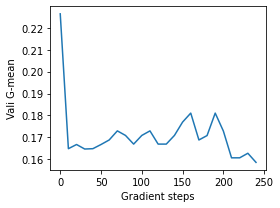


Vali G-mean: 0.1584
Test G-mean: 0.1777


In [17]:
model_as = surrogate_pgd(
    x_train, y_train, z_train, x_vali, y_vali, z_vali, surrogate_fn, 
    surrogate_tensor_fn, metric_fn)
print_results(model_as, x_vali, y_vali, x_test, y_test)

The proposed method yields a better G-mean value on both the validation and the test sets compared to the two baselines.